# Setup

In [160]:
%%capture
%pip install kmodes

In [161]:
import pandas as pd
import numpy as np

# Data vizualization
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express  as px
import plotly.graph_objects as go

from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance, kelbow_visualizer, silhouette_visualizer


# machine learning
from sklearn import datasets
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans, DBSCAN, MeanShift
from sklearn.cluster import k_means, dbscan, mean_shift, estimate_bandwidth
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale, PowerTransformer

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

from kmodes.kmodes import KModes            # clustering categorical data
from kmodes.kprototypes import KPrototypes  # clustering mixed data

# Didatic purposes
import string
from ipywidgets import interact

In [162]:
# https://matplotlib.org/stable/tutorials/introductory/customizing.html
sns.set_theme(
    context='talk',
    style='ticks',
    font_scale=.8,
    palette='tab10',
    rc={
        'figure.figsize': (12,8),
        'axes.grid': True,
        'grid.alpha': .2,
        'axes.titlesize': 'x-large',
        'axes.titleweight': 'bold',
        'axes.titlepad': 20,
    }
)

scatter_kwargs = dict(palette='viridis', alpha=0.8, linewidth=0)

# Data Understanding

In [163]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DNC Desafios/data.csv', encoding='latin1')

In [164]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [165]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [166]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


Perguntas de negocio

In [167]:
# Quantidade de produtos e
df[['Description','Country']].nunique()

Description    4223
Country          38
dtype: int64

<Axes: >

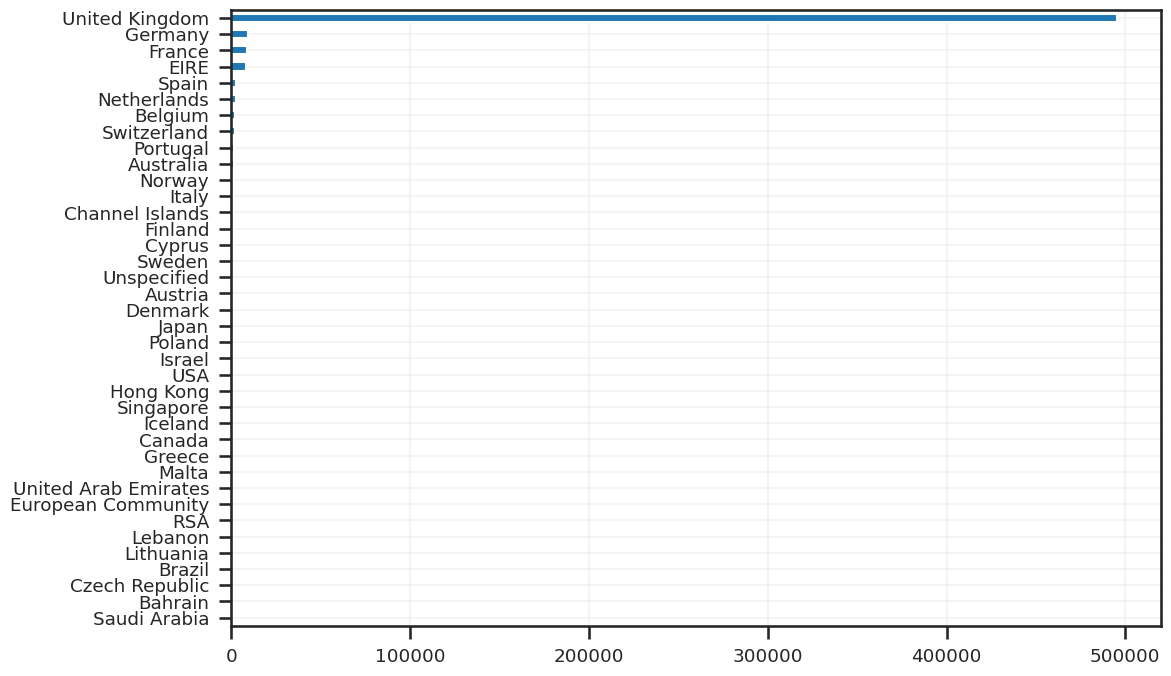

In [168]:
# Plotando os paises que tem mais vendas
df['Country'].value_counts(ascending=True).plot.barh()

# Vemos que a grande maioria das vendas foi feita no reino unido

In [169]:
# Verificando os 10 produtos mais vendidos
df['Description'].value_counts().sort_values(ascending=False).reset_index().head(10)

,index,Description
0,WHITE HANGING HEART T-LIGHT HOLDER,2369
1,REGENCY CAKESTAND 3 TIER,2200
2,JUMBO BAG RED RETROSPOT,2159
3,PARTY BUNTING,1727
4,LUNCH BAG RED RETROSPOT,1638
5,ASSORTED COLOUR BIRD ORNAMENT,1501
6,SET OF 3 CAKE TINS PANTRY DESIGN,1473
7,PACK OF 72 RETROSPOT CAKE CASES,1385
8,LUNCH BAG BLACK SKULL.,1350
9,NATURAL SLATE HEART CHALKBOARD,1280


In [170]:
df.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [171]:
df.duplicated().sum()

5268

### Pontos visto no understanding:

- Arrumar o formato da data
- CustomerID para int
- Reomver os nulos
- Remover os outliers das colunas Quantity e UnitPrice
- Remover os duplicados

# Data Cleaning

In [172]:
# Removendo os nulos
df.dropna(inplace=True)


In [173]:
# Removendo os dados duplicados
df.drop_duplicates(inplace=True)

In [174]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 401604 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    401604 non-null  object 
 1   StockCode    401604 non-null  object 
 2   Description  401604 non-null  object 
 3   Quantity     401604 non-null  int64  
 4   InvoiceDate  401604 non-null  object 
 5   UnitPrice    401604 non-null  float64
 6   CustomerID   401604 non-null  float64
 7   Country      401604 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 27.6+ MB


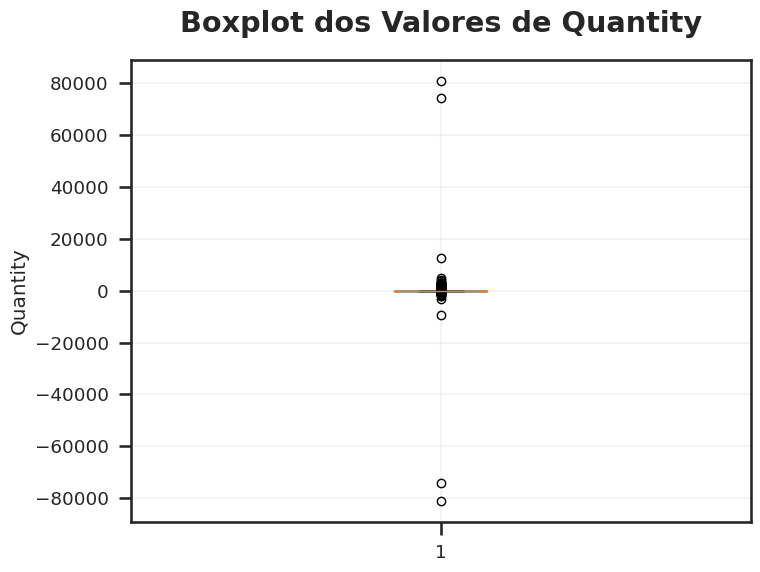

In [175]:
# Verificando os outliers e removendo
plt.figure(figsize=(8, 6))
plt.boxplot(df['Quantity'])
plt.title('Boxplot dos Valores de Quantity')
plt.ylabel('Quantity')
plt.show()

# Temos dados muito fora do padrão para as duas colunas

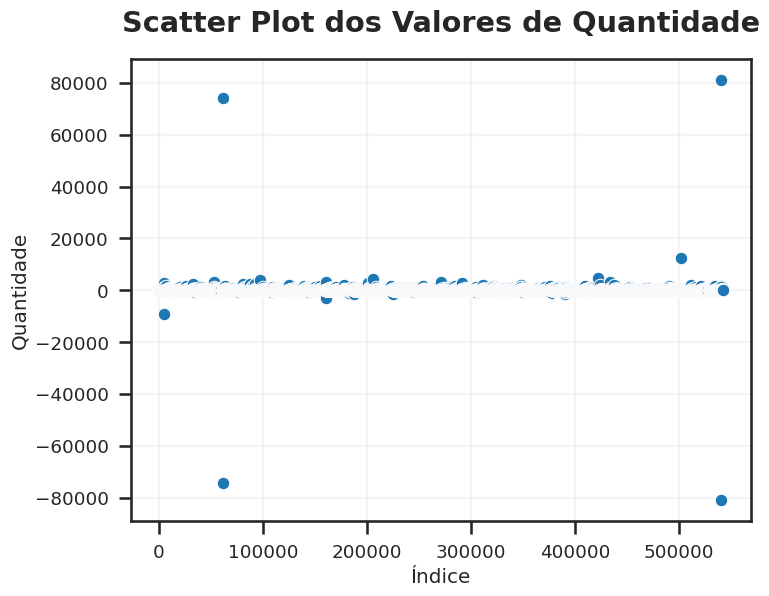

In [176]:
# Plotando um scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x=df.index, y='Quantity')
plt.title('Scatter Plot dos Valores de Quantidade')
plt.ylabel('Quantidade')
plt.xlabel('Índice')
plt.show()

In [177]:
# Removendo os outliers
df = df.query('Quantity<= 20000  and Quantity>=0')

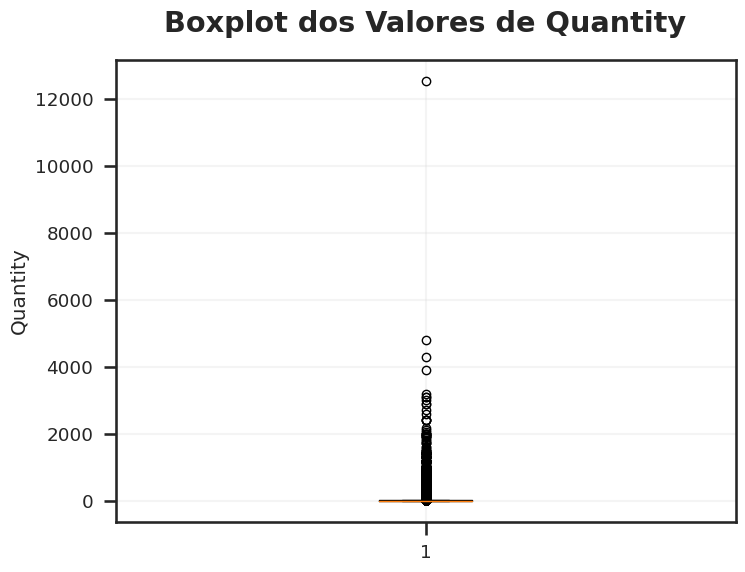

In [178]:
plt.figure(figsize=(8, 6))
plt.boxplot(df['Quantity'])
plt.title('Boxplot dos Valores de Quantity')
plt.ylabel('Quantity')
plt.show()

# Ainda temos um valor bem outliers, vamos remover

In [179]:
df = df.query('Quantity<= 10000')

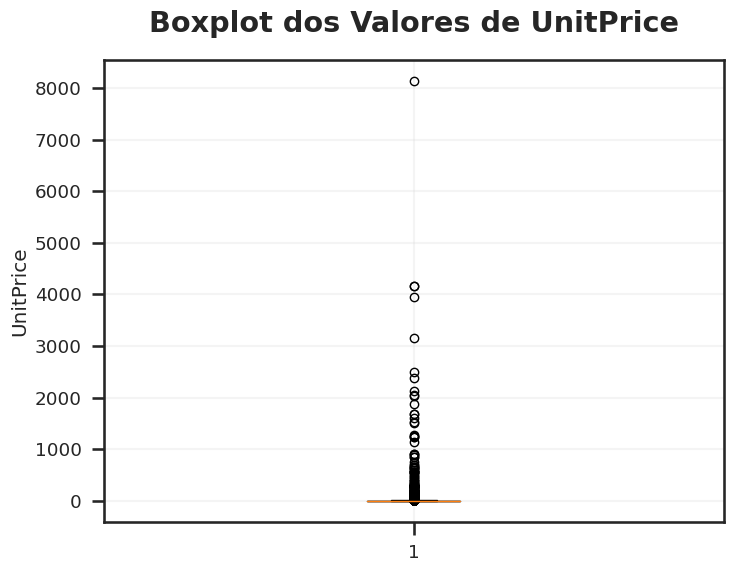

In [180]:
# Verificando Unitprice
plt.figure(figsize=(8, 6))
plt.boxplot(df['UnitPrice'])
plt.title('Boxplot dos Valores de UnitPrice')
plt.ylabel('UnitPrice')
plt.show()

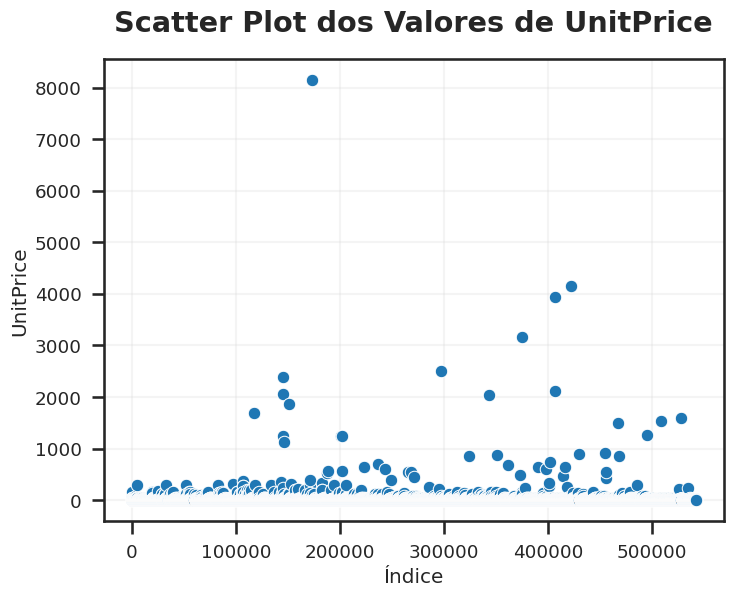

In [181]:
# Plotando um scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x=df.index, y='UnitPrice')
plt.title('Scatter Plot dos Valores de UnitPrice')
plt.ylabel('UnitPrice')
plt.xlabel('Índice')
plt.show()

In [182]:
# Removendo os outliers
df = df.query('UnitPrice<= 5000  and Quantity>=0')

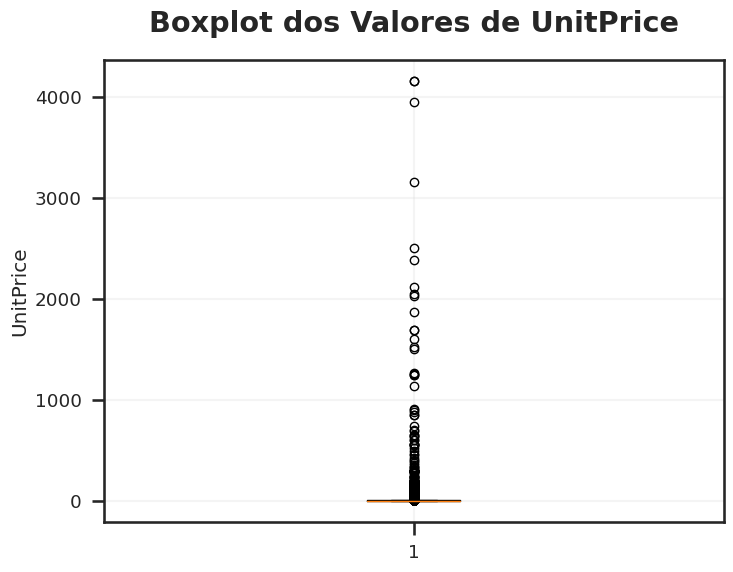

In [183]:
# Verificando Unitprice
plt.figure(figsize=(8, 6))
plt.boxplot(df['UnitPrice'])
plt.title('Boxplot dos Valores de UnitPrice')
plt.ylabel('UnitPrice')
plt.show()

# Data Preparation

In [184]:
# Convertendo para o formato de data
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [185]:
# Coluna de CustomerID para int
df['CustomerID'] = df['CustomerID'].astype(int)

In [186]:
# Mostrando a data maxima e minima do problema
df.InvoiceDate.agg(['min','max'])

min   2010-12-01 08:26:00
max   2011-12-09 12:50:00
Name: InvoiceDate, dtype: datetime64[ns]

In [187]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


In [188]:
# Adicionando a coluna de total de compra
df['Total_Compra'] =  df['Quantity'] * df['UnitPrice']
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total_Compra
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


## Normalizando os dados e separando os valores mais importantes

os valores que estão sendo colocados aqui são:

RFM:
- R (Recency): Tempo que o cliente realizou a última compra (em dias)
- F (Frequency): Quantidade de compras realizadas pelo cliente
- M (Monetary): Valor do **ticket médio** gasto pelo cliente



In [189]:
# Criando um novo dataframe para ser usado com o cluster que atende algumas perguntas

df_rfm = (
  df.groupby('CustomerID')
  .agg(
      R = ('InvoiceDate', lambda x: (pd.Timestamp('01-01-2012') - x.max()).days),
      F = ('InvoiceNo', 'nunique'),
      M = ('Total_Compra', 'mean')
  )
)

df_rfm.head()

,R,F,M
CustomerID,,,
12347,24,7,23.681319
12348,97,4,57.975484
12349,40,1,24.076027
12350,332,1,19.670588
12352,58,8,29.482824


<Axes: >

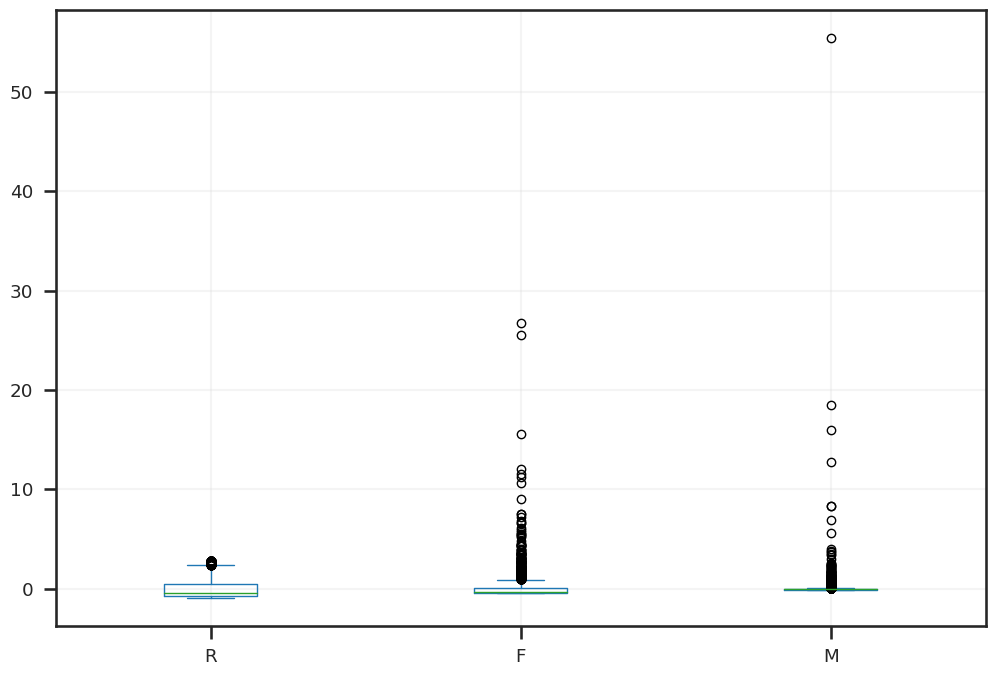

In [190]:
# Aplicando escala no dataframe
df_scaled =df_rfm.apply(scale)
df_scaled.plot.box()

Podemos ver que mesmo retirando outliers de estapas anteriores é importante remover este em questão para o modelo não perder precisão

In [191]:
# Encontrando esse valor que está com valor M muito alto
df_scaled[df_scaled['M']>50]

,R,F,M
CustomerID,,,
15098,0.899878,-0.16523,55.442267


In [192]:
# verificando o que temos com esse customer ID
df[df['CustomerID']==15098]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total_Compra
222670,556442,22502,PICNIC BASKET WICKER SMALL,60,2011-06-10 15:22:00,4.95,15098,United Kingdom,297.0
222680,556444,22502,PICNIC BASKET WICKER 60 PIECES,60,2011-06-10 15:28:00,649.50,15098,United Kingdom,38970.0
222682,556446,22502,PICNIC BASKET WICKER 60 PIECES,1,2011-06-10 15:33:00,649.50,15098,United Kingdom,649.5


Podemos observr que esse cliente tem uma grande quantidade de item comprados e um preço muito elevado, como são poucos dados isso vai ser retirado

In [193]:
df_rfm = df_rfm.drop(15098)

<Axes: >

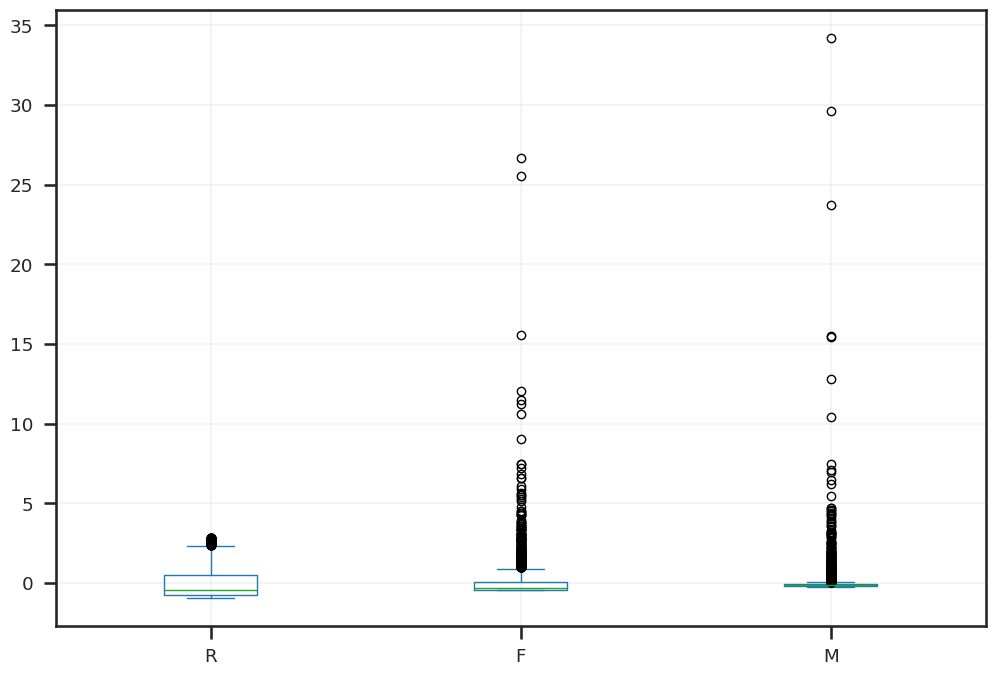

In [194]:
df_rfm.apply(scale).plot.box()

In [195]:
# Utilizando o Power Transform para acertar a escala dos dados
# é uma técnica de pré-processamento de dados que transforma as variáveis para que elas tenham uma distribuição mais gaussiana
scaler = PowerTransformer()

In [196]:
df_scaled_rfm =  pd.DataFrame(scaler.fit_transform(df_rfm), index=df_rfm.index, columns=df_rfm.columns)
df_scaled_rfm.head()

,R,F,M
CustomerID,,,
12347,-1.563219,1.201760,0.407306
12348,0.323470,0.660559,1.331556
12349,-0.809134,-1.158055,0.426389
12350,1.568467,-1.158055,0.187729
12352,-0.307718,1.309570,0.653941


<Axes: >

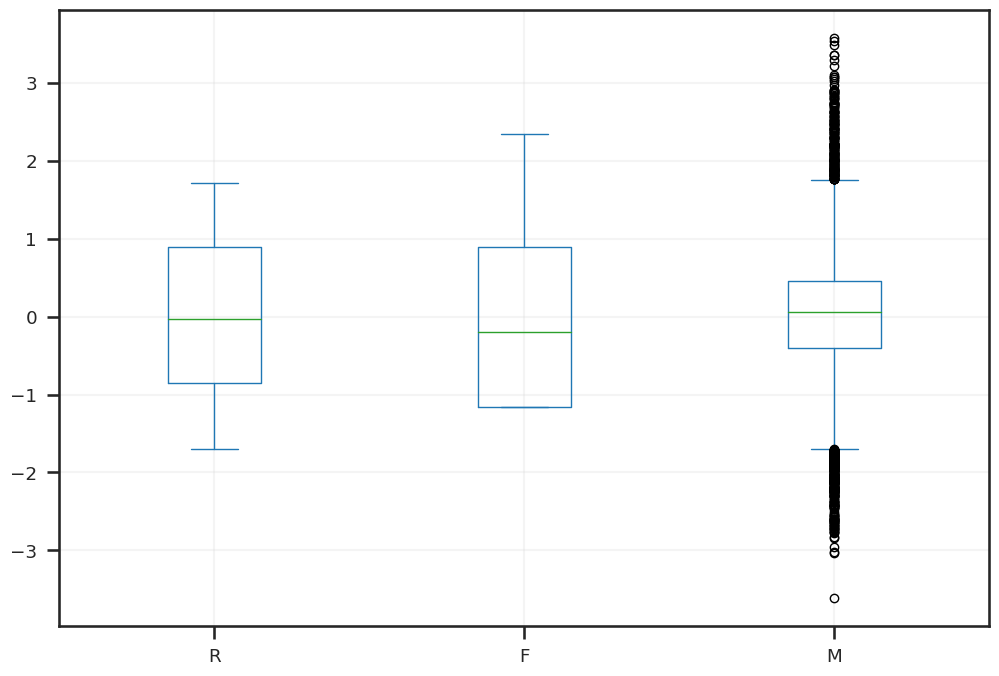

In [197]:
df_scaled_rfm.plot.box()
# aqi podemos observar de mais uma maneira como estão distribuidos os dados e é visto que podemos ainda ter outliers neste modelo
# Isso irá ser investigado

In [198]:
# Verificando metricas das colunas
df_rfm.describe()

# Verificado que ainda temos valores que estão muito distantes dos demais

,R,F,M
count,4336.000000,4336.000000,4336.000000
mean,114.032288,4.273293,34.554131
std,99.968352,7.706154,129.143523
min,22.000000,1.000000,1.450000
25%,39.000000,1.000000,12.381225
50%,72.000000,2.000000,17.728162
75%,163.250000,5.000000,24.849458
max,395.000000,210.000000,4453.430000


In [199]:
# limitando os valores a 95% em vez dos 100% que pareciam estar contendo outliers
df_rfm_clip = df_rfm.apply(lambda x: x.clip(upper=x.quantile(.95)))
df_rfm_clip.describe()

,R,F,M
count,4336.000000,4336.000000,4336.000000
mean,112.248155,3.608395,23.659546
std,95.504576,3.359061,20.977538
min,22.000000,1.000000,1.450000
25%,39.000000,1.000000,12.381225
50%,72.000000,2.000000,17.728162
75%,163.250000,5.000000,24.849458
max,333.000000,13.000000,91.768421


<Axes: >

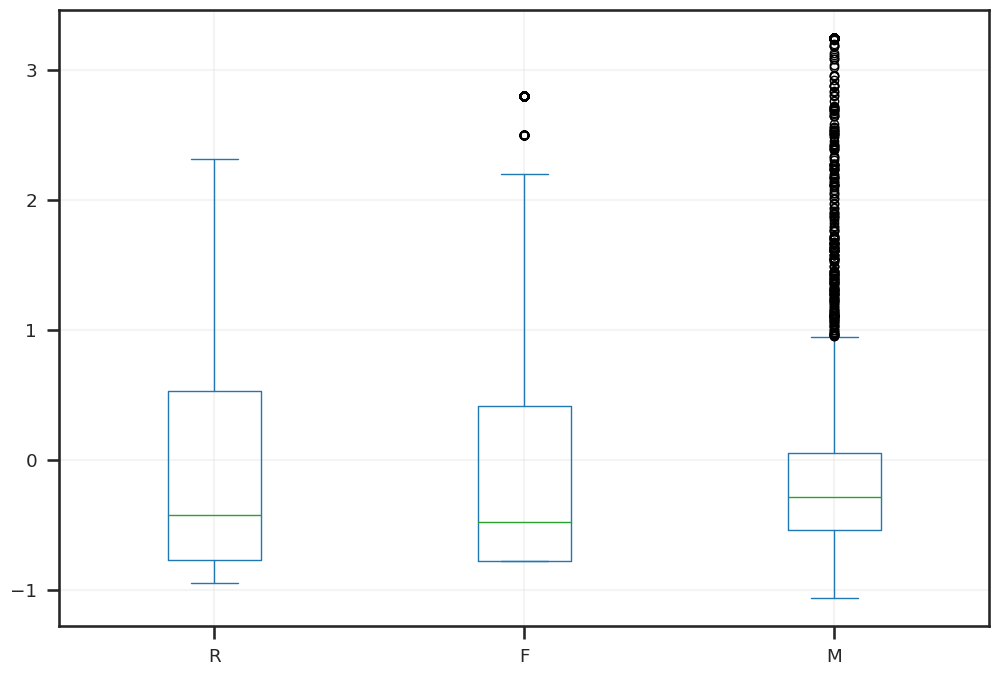

In [200]:
# Aplicando a escala definitiva
df_tratado = df_rfm_clip.apply(scale)
df_tratado.plot.box()

# Modeling


## Kmeans

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

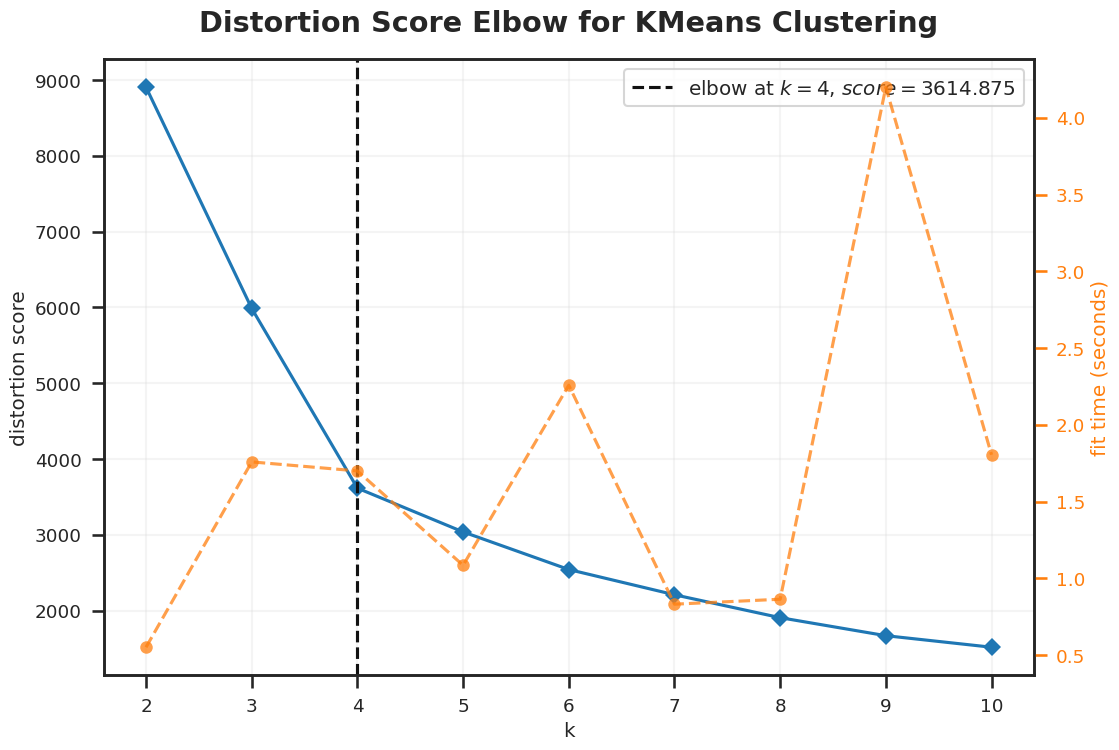

KElbowVisualizer(ax=<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>,
                 estimator=KMeans(n_clusters=10))

In [201]:
# Vizualizando o método do kelbow
kelbow_visualizer(KMeans(), df_tratado, k=10, timing=False)

o método do cotovelo nos retornou que usando um numero de 4 clusters seria o ideal e tudo indica que é isso mesmo, o avanço da queda se torna pouco significante com os demais valores

In [203]:
# Criando uma lista de dicionarios para todas as metricas

cluster_metrics = silhouette_score, davies_bouldin_score, calinski_harabasz_score
cluster_metrics_results = []

x = df_tratado.copy()


for k in range(2,11):
  model = KMeans(n_clusters=k, random_state=0)
  labels = model.fit_predict(x)
  cluster_results_dict = {'k': k}
  cluster_results_dict['inertia'] = model.inertia_
  for metric in cluster_metrics:
    cluster_results_dict[metric.__name__] = metric(x, labels)
  cluster_metrics_results.append(cluster_results_dict)

pd.DataFrame(cluster_metrics_results).set_index('k').style.background_gradient()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

,inertia,silhouette_score,davies_bouldin_score,calinski_harabasz_score
k,,,,
2,8906.639372,0.382384,1.065337,1995.757617
3,5986.667936,0.434291,0.858711,2540.931964
4,3614.882115,0.479627,0.704401,3752.183493
5,3037.477427,0.484990,0.737613,3554.127916
6,2541.167717,0.398267,0.850703,3566.973049
7,2207.872268,0.377050,0.869874,3529.321995
8,1904.209095,0.383859,0.868741,3605.336887
9,1667.809100,0.394160,0.800834,3677.658482
10,1515.558513,0.351791,0.887723,3644.883055


Com esse gráfico podemos observar que os as metricas mais interessantes e com os melhores valores estão com o número de cluster 4

Utilizando o Kmeans para verificar como ficam agrupados os clientes

In [204]:
# Passando o valor de 4 cluster para o modelo usar
kmeans = KMeans(4)
kmeans_labels = kmeans.fit_predict(df_tratado)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


# Analise dos clusters

In [205]:
# Plotando o gráfico
px.scatter_3d(df_rfm_clip, x='R', y='F', z='M', color=kmeans_labels.astype(str), template='plotly_dark')

In [206]:
# Passando o valor de 4 cluster para o modelo usar
kmeans = KMeans(5)
kmeans_labels = kmeans.fit_predict(df_tratado)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



In [207]:
px.scatter_3d(df_rfm_clip, x='R', y='F', z='M', color=kmeans_labels.astype(str), template='plotly_dark')

# Interpretação dos resultados

- **Roxo**: São clientes que fizeram poucas compras e não voltaram, e os valores de compra deles não foram muito altos.

- **Azul: Representa** clientes fiéis e recorrentes, que fazem compras com frequência e são leais ao  e-commerce.

- **Verde Claro**: Indica clientes novos que fizeram poucas compras, têm uma frequência baixa de compras e são considerados recentes na base de clientes.

- **Vermelho**: Estes são clientes que fizeram compras caras, mas não fizeram muitas compras subsequentes. Eles foram difíceis de reter, pois a maioria deles não voltou a fazer compras.

- **Bege**: São clientes que gastaram muito e retornaram para fazer compras novamente, mostrando uma tendência de repetição de compras.

Apesar de 4 cluster terem sido os sugeridos, acredito que com 5 ficou melhor segmentado para este problema, explicando em sequencia um grupo de clientes que gastam mais e são fies ao  e-commerce

## Medidas seguridas

**Clientes Fieis (Azul):**

Estes clientes são valiosos, pois são recorrentes e leais ao e-commerce.
Medida sugerida: Oferecer programas de fidelidade, descontos exclusivos ou benefícios especiais para incentivar ainda mais a sua fidelidade. Além disso, coletar feedback regularmente para entender suas necessidades e preferências pode ajudar a manter sua lealdade.


**Clientes Novos (Verde Claro):**

Esses clientes acabaram de fazer sua primeira compra, indicando potencial para desenvolver um relacionamento a longo prazo.
Medida sugerida: Implementar estratégias de engajamento e nutrição para incentivar esses clientes a retornarem e fazerem compras adicionais. Isso pode incluir o envio de e-mails de boas-vindas, oferecer descontos para a segunda compra ou fornecer conteúdo relevante para manter o interesse deles.


**Clientes que Gastaram Muito e Voltaram (Bege):**

Esses clientes gastaram muito e demonstraram um padrão de repetição de compras.
Medida sugerida: Continuar a oferecer produtos e serviços de alta qualidade para manter esses clientes engajados. Além disso, programas de recompensa ou de indicação podem incentivá-los a continuar comprando e a trazer novos clientes para o negócio.


**Clientes que Gastaram Mais e Não Voltaram (Vermelho):**

Embora tenham feito compras caras, esses clientes não fizeram muitas compras subsequentes.
Medida sugerida: Investigar as razões pelas quais esses clientes não retornaram e implementar estratégias para reconquistá-los, como campanhas de reativação, descontos exclusivos ou solicitação de feedback para entender o que pode ter levado à falta de retorno.

**Clientes que Compraram Poucas Vezes e Não Voltaram (Roxo):**

Estes clientes fizeram poucas compras e não mostraram sinais de lealdade.
Medida sugerida: Segmentar esses clientes com campanhas de marketing personalizadas para tentar recuperá-los. Isso pode incluir ofertas especiais, recomendações de produtos com base em suas compras anteriores ou solicitação de feedback para entender por que eles não retornaram.

Com base nessa análise, o e-commerce pode adotar medidas direcionadas para manter e melhorar as relações com clientes específicos. Além disso, foi observado que a maioria das vendas está concentrada no Reino Unido, sugerindo a possibilidade de expandir essa área de vendas e atrair novos clientes. Isso poderia ser alcançado através de uma campanha de marketing direcionada ou oferecendo incentivos para novos compradores de fora do Reino Unido.